In [15]:
# Import libraries
import operator
import sys, os
from enum import Enum
from pprint import pprint
from pydantic import BaseModel
from typing_extensions import TypedDict
from IPython.display import Image, display
from typing import List, Dict, Optional, Annotated

from langchain_core.tools import tool
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, RemoveMessage, AnyMessage

from langgraph.types import Send
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition

In [2]:
# Import settings and sensitive variables from config
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from codes.config.config import config

2025-09-11 22:17:38,889 - root - INFO - Configuration loaded for environment: development


# Map-Reduce

Map-reduce is used for task decomposition. It has two phases:
1. **Map:** Break a task into smaller sub-tasks, processing each sub-task in parallel.
2. **Reduce:** Aggregate the results across all of the completed sub-tasks.

In this notebook, we design a system that:
1. **Map:** Create a set of jokes about a topic.
2. **Reduce:** Pick the best joke from the list.


In [3]:
model = ChatGoogleGenerativeAI(model=config.model.model_name, api_key=config.model.api_key)

subjects_prompt = PromptTemplate(
    input_variables=["topic"],
    template="Generate a list of 3 sub-tasks that are all related to this overall topic: {topic}"
)

joke_prompt = PromptTemplate(
    input_variables=["subject"],
    template="Generate a joke about {subject}"
)

best_joke_prompt = PromptTemplate(
    input_variables=["topic", "jokes"],
    template="Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}"
)

In [69]:
class Subjects(BaseModel):
    subjects: list[str]

class BestJoke(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

In [70]:
"""
Here is where the magic happens, we use Send API. This function takes a list from the main state and creates a multi parallel executuin
of the target node!
"""
def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

In [71]:
# MAP
class JokeState(TypedDict):
    subject: str

class Joke(BaseModel):
    joke: str

def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

In [72]:
# REDUCE
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

2025-09-11 13:43:54,163 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): mermaid.ink:443
2025-09-11 13:43:54,455 - urllib3.connectionpool - DEBUG - https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCWdlbmVyYXRlX3RvcGljcyhnZW5lcmF0ZV90b3BpY3MpCglnZW5lcmF0ZV9qb2tlKGdlbmVyYXRlX2pva2UpCgliZXN0X2pva2UoYmVzdF9qb2tlKQoJX19lbmRfXyhbPHA+X19lbmRfXzwvcD5dKTo6Omxhc3QKCV9fc3RhcnRfXyAtLT4gZ2VuZXJhdGVfdG9waWNzOwoJZ2VuZXJhdGVfam9rZSAtLT4gYmVzdF9qb2tlOwoJZ2VuZXJhdGVfdG9waWNzIC0uLT4gZ2VuZXJhdGVfam9rZTsKCWJlc3Rfam9rZSAtLT4gX19lbmRfXzsKCWNsYXNzRGVmIGRlZmF1bHQgZmlsbDojZjJmMGZmLGxpbmUtaGVpZ2h0OjEuMgoJY2xhc3NEZWYgZmlyc3QgZmlsbC1vcGFjaXR5OjAKCWNsYXNzRGVmIGxhc3QgZmlsbDojYmZiNmZjCg==?type=png&bgColor=!white HTTP/1.1" 200 13521


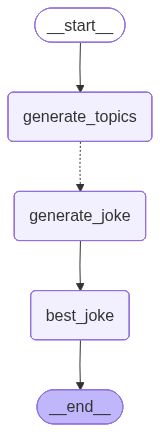

In [73]:
# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())


In [75]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['animal habitats', 'animal diets', 'animal behavior']}}
{'generate_joke': {'jokes': ["Why did the bear break up with the badger? Because they weren't on the same common ground when it came to their habitats!"]}}
{'generate_joke': {'jokes': ['Why did the behavioral ecologist break up with the zoologist? Because he was always lion!']}}
{'generate_joke': {'jokes': ['Why did the vegan animal break up with the carnivore? They had irreconcilable dietary differences!']}}
{'best_joke': {'best_selected_joke': 'Why did the behavioral ecologist break up with the zoologist? Because he was always lion!'}}


---
# Travel Planner

For the next practice, we create a travel planer agent using map-reduce technique. User inputs the city name with number of days, and this agent creates best activities in the target city in parallel, and create a daily plan.

In [92]:
# Create Prompts
generate_categories_prompt = PromptTemplate(
    input_variables=["city", "days"],
    template="""You are a professional travel expert specializing in {city}. 
Generate exactly {days} distinct activity categories perfect for a {days}-day trip to {city}.

Requirements:
- Each category should represent a full day's worth of activities
- Categories should be diverse (culture, nature, food, adventure, relaxation, etc.)
- Consider {city}'s unique attractions and seasonal factors
- Avoid overlapping categories
- Focus on experiences that showcase {city}'s character

Think through this step-by-step:
1. First, consider what makes {city} unique
2. Then, think about the logical flow of activities
3. Finally, structure the recommendations
"""
)

generate_recommendation_prompt = PromptTemplate(
    input_variables=["city", "category"],
    template="""You are a local expert guide for {city}. Create a detailed one-day plan for {category} activities.

Requirements:
- Include 4-6 specific locations/activities
- Provide realistic timing (morning, afternoon, evening)
- Include practical details: opening hours, approximate costs, transportation
- Suggest 2-3 dining options that fit the day's theme
- Add one "local secret" or lesser-known spot
- Consider travel time between locations

Think through this step-by-step:
1. First, consider what makes {city} unique
2. Then, think about the logical flow of activities
3. Finally, structure the recommendations
"""
)

planner_prompt = PromptTemplate(
    input_variables=["city", "days", "recommendations"],
    template="""You are a professional travel consultant creating a final itinerary for a {days}-day trip to {city}.

Input Data: {recommendations}

Create a cohesive, well-structured itinerary that:

STRUCTURE:
- Organize by day with clear headers (Day 1, Day 2, etc.)
- Balance activity intensity (mix active/relaxing days)
- Consider logical geographic flow to minimize travel time
- Include buffer time for rest and spontaneous exploration

PRACTICAL ELEMENTS:
- Estimated daily budget breakdown
- Transportation between major areas
- Weather considerations and backup indoor options
- Cultural etiquette tips specific to {city}

FORMAT:
# {city} {days}-Day Itinerary

## Overview
- Total estimated budget: [amount]
- Best time to visit: [season/months]
- Transportation: [main methods]

## Day 1: [Theme/Focus]
**Morning:** [activities with timing]
**Afternoon:** [activities with timing] 
**Evening:** [activities with timing]
**Daily Budget:** [amount]
**Pro Tip:** [local insight]

[Repeat for each day]

## Essential Travel Info
- Currency & tipping customs
- Key phrases in local language
- Emergency contacts
- Cultural do's and don'ts

Make this itinerary feel personal and exciting, not like a generic travel guide.
"""
)

In [93]:
# Structured outputs
class ActivityCategories(BaseModel):
    categories: List[str]

class DayRecommendation(BaseModel):
    category: str
    morning_activity: str
    afternoon_activity: str
    evening_activity: str
    estimated_cost: float
    pro_tip: str
    full_day_plan: str

class FinalItinerary(BaseModel):
    itinerary: str
    total_budget: float
    travel_tips: List[str]

In [94]:
# States
class TravelState(TypedDict):
    city: str 
    days: int 
    activity_categories: List[str]
    daily_recommendations: Annotated[List[str], add]
    final_itinerary: str

class ActivityState(TypedDict):
    city: str
    category: str

In [95]:
# Nodes
def generate_activity_categories(state: TravelState):
    """Generate list of activity categories for the trip"""
    prompt = generate_categories_prompt.format(
        city=state["city"], 
        days=state["days"]
    )
    
    response = model.with_structured_output(ActivityCategories).invoke(prompt)
    return {"activity_categories": response.categories}


def generate_recommendation(state: ActivityState):
    """Generate detailed recommendation for one activity category"""
    prompt = generate_recommendation_prompt.format(
        city=state["city"],
        category=state["category"]
    )
    
    response = model.with_structured_output(DayRecommendation).invoke(prompt)
    
    # Return as list for the reducer to combine
    return {"daily_recommendations": [response.full_day_plan]}


def continue_to_recommendations(state: TravelState):
    """Create Send objects for each activity category"""
    return [
        Send("generate_recommendation", {
            "city": state["city"],
            "category": category
        }) 
        for category in state["activity_categories"]
    ]


def create_final_itinerary(state: TravelState):
    """Combine all recommendations into final itinerary"""
    recommendations_text = "\n\n".join(state["daily_recommendations"])
    
    prompt = planner_prompt.format(
        city=state["city"],
        days=state["days"],
        recommendations=recommendations_text
    )
    
    response = model.with_structured_output(FinalItinerary).invoke(prompt)
    return {"final_itinerary": response.itinerary}

2025-09-11 14:13:28,117 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): mermaid.ink:443
2025-09-11 14:13:28,356 - urllib3.connectionpool - DEBUG - https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCWdlbmVyYXRlX2NhdGVnb3JpZXMoZ2VuZXJhdGVfY2F0ZWdvcmllcykKCWdlbmVyYXRlX3JlY29tbWVuZGF0aW9uKGdlbmVyYXRlX3JlY29tbWVuZGF0aW9uKQoJY3JlYXRlX2l0aW5lcmFyeShjcmVhdGVfaXRpbmVyYXJ5KQoJX19lbmRfXyhbPHA+X19lbmRfXzwvcD5dKTo6Omxhc3QKCV9fc3RhcnRfXyAtLT4gZ2VuZXJhdGVfY2F0ZWdvcmllczsKCWdlbmVyYXRlX2NhdGVnb3JpZXMgLS4tPiBnZW5lcmF0ZV9yZWNvbW1lbmRhdGlvbjsKCWdlbmVyYXRlX3JlY29tbWVuZGF0aW9uIC0tPiBjcmVhdGVfaXRpbmVyYXJ5OwoJY3JlYXRlX2l0aW5lcmFyeSAtLT4gX19lbmRfXzsKCWNsYXNzRGVmIGRlZmF1bHQgZmlsbDojZjJmMGZmLGxpbmUtaGVpZ2h0OjEuMgoJY2xhc3NEZWYgZmlyc3QgZmlsbC1vcGFjaXR5OjAKCWNsYXNzRGVmIGxhc3QgZmlsbDojYmZiNmZjCg==?type=png&bgColor=!white HTTP/1.1" 200 16043


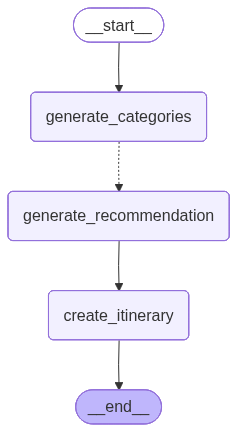

In [96]:
# Build the graph
graph_builder = StateGraph(TravelState)

# Add nodes
graph_builder.add_node("generate_categories", generate_activity_categories)
graph_builder.add_node("generate_recommendation", generate_recommendation)  # Will run in parallel
graph_builder.add_node("create_itinerary", create_final_itinerary)

# Add edges
graph_builder.add_edge(START, "generate_categories")

# Critical: Conditional edge with Send for map-reduce
graph_builder.add_conditional_edges(
    "generate_categories", 
    continue_to_recommendations,  # This creates the parallel Send objects
    ["generate_recommendation"]   # Possible destinations
)

graph_builder.add_edge("generate_recommendation", "create_itinerary")
graph_builder.add_edge("create_itinerary", END)

# Compile
travel_planner = graph_builder.compile()
Image(travel_planner.get_graph().draw_mermaid_png())

In [98]:
test_input = {
    "city": "Hamedan, Iran",
    "days": 3,
    "activity_categories": [],
    "daily_recommendations": [],
    "final_itinerary": ""
}

# Run the graph
result = travel_planner.invoke(test_input)

# Check results
print("=== ACTIVITY CATEGORIES ===")
print(result["activity_categories"])

print("\n=== DAILY RECOMMENDATIONS ===")
for i, rec in enumerate(result["daily_recommendations"], 1):
    print(f"Day {i} Plan:")
    print(rec)
    print("-" * 50)

print("\n=== FINAL ITINERARY ===")
print(result["final_itinerary"])

=== ACTIVITY CATEGORIES ===
['Ancient History & Intellectual Heritage', 'Subterranean Wonders & Mountain Views', 'Archaeological Depths & Urban Charm']

=== DAILY RECOMMENDATIONS ===
Day 1 Plan:
Your day begins by stepping back in time at **Hegmataneh (Ecbatana) Ancient City** (9:00 AM - 11:30 AM), the site of the ancient Median capital. Explore its archaeological layers and museum, gaining insight into thousands of years of history. Afterwards, a scenic taxi ride takes you to **Ganjnameh Inscriptions** (11:45 AM - 1:00 PM), where you'll marvel at Achaemenid rock carvings and enjoy the mountainous landscape. Lunch will be at a traditional restaurant, either near Ganjnameh or upon returning to the city center. The afternoon is dedicated to Hamedan's intellectual giants. First, visit the majestic **Tomb of Avicenna (Ibn Sina)** (2:30 PM - 4:00 PM), a must-see for anyone interested in science and philosophy. A short taxi ride then brings you to the tranquil **Tomb of Baba Taher** (4:15 PM

---
# Example 3: Learning Roadmap Creator

1. **Input:** Skill to learn + current level + time available
2. **Map:** Generate learning areas (theory, practice, projects, assessments)
3. **Process:** Create detailed study plans for each area in parallel
4. **Reduce:** Sequence into complete learning roadmap with milestones

In [9]:
llm = ChatGoogleGenerativeAI(model=config.model.model_name, api_key=config.model.api_key)

In [43]:
# States
class Level(str, Enum):
    """ Current understanding level of the topic. """
    BEGINNER: str = "beginner"
    INTERMEDIATE: str = "intermediate"
    ADVANCED: str = "advanced"

class MainState(TypedDict):
    """ Main graph state. """
    topic: str
    level: Level
    time_available: str

    learning_areas: Optional[List[str]]
    study_plans: Annotated[list, operator.add]

    final_plan: Optional[str]

class MapNodeOutput(BaseModel):
    sub_areas: List[str]
    
class ProcessNodeInput(TypedDict):
    topic: str
    sub_area: str
    level: Level

class ProcessNodeOutput(BaseModel):
    study_plan: str

In [44]:
map_prompt = PromptTemplate(
    input_variables=["topic", "level"],
    template="""You are professional tutor of {topic}. You help people to learn {topic} by breaking the main topic into smaller sub-areas, which people
should focus in their learning curve. When you give answer, please make sure you include all aspects for effective learning such as theory,
practices, hands-on projects, etc...

When you want to give ansewr:
1- First think about what sub-areas are needed to learn in order to learn main topic.
2- Then create a list of all necessary steps.

Now create all necessary topics needed to master {topic} for a person with {level} understanding of the topic.
"""
)

process_prompt = PromptTemplate(
    input_variables=["topic", "sub_area", "level"],
    template="""You are professional tutor of {topic}. Craft a detailed study plan for {sub_area} for a person with {level} understanding of the topic"""
)

reduce_prompt = PromptTemplate(
    input_variables=["topic", "time_available", "study_plans"],
    template="""You are professional tutor of {topic}. Please review the delimited study plans and create a detailed daily plan for daily {time_available} learning.
    study plans: ```{study_plans}```
    """
)

In [47]:
# Nodes
def map_node(state: MainState):
    prompt = map_prompt.format(
        topic=state["topic"],
        level=state["level"]
    )
    
    response = llm.with_structured_output(MapNodeOutput).invoke(prompt)
    return {"learning_areas": response.sub_areas}

def process_node(state: ProcessNodeInput):
    prompt = process_prompt.format(
        topic=state["topic"],
        sub_area=state["sub_area"],
        level=state["level"],
    )

    response = llm.with_structured_output(ProcessNodeOutput).invoke(prompt)
    return {"study_plans": [response.study_plan]}


def distribute_process_job(state: MainState):
    return [Send(
        "process_node", 
        {
            "topic": state['topic'], 
            "sub_area": sub_area, 
            "level": state['level']
        }) for sub_area in state["learning_areas"]]


def reduce_node(state: MainState):
    prompt = reduce_prompt.format(
        topic=state["topic"],
        time_available=state["time_available"],
        study_plans="\n\n".join(state["study_plans"])
    )

    response = llm.invoke(prompt)

    return {"final_plan": response.content}

2025-09-11 22:43:02,565 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): mermaid.ink:443
2025-09-11 22:43:02,960 - urllib3.connectionpool - DEBUG - https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCW1hcF9ub2RlKG1hcF9ub2RlKQoJcHJvY2Vzc19ub2RlKHByb2Nlc3Nfbm9kZSkKCXJlZHVjZV9ub2RlKHJlZHVjZV9ub2RlKQoJX19lbmRfXyhbPHA+X19lbmRfXzwvcD5dKTo6Omxhc3QKCV9fc3RhcnRfXyAtLT4gbWFwX25vZGU7CgltYXBfbm9kZSAtLi0+IHByb2Nlc3Nfbm9kZTsKCXByb2Nlc3Nfbm9kZSAtLT4gcmVkdWNlX25vZGU7CglyZWR1Y2Vfbm9kZSAtLT4gX19lbmRfXzsKCWNsYXNzRGVmIGRlZmF1bHQgZmlsbDojZjJmMGZmLGxpbmUtaGVpZ2h0OjEuMgoJY2xhc3NEZWYgZmlyc3QgZmlsbC1vcGFjaXR5OjAKCWNsYXNzRGVmIGxhc3QgZmlsbDojYmZiNmZjCg==?type=png&bgColor=!white HTTP/1.1" 200 12633


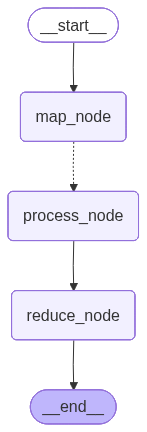

In [48]:
builder = StateGraph(MainState)

builder.add_node("map_node", map_node)
builder.add_node("process_node", process_node)
builder.add_node("reduce_node", reduce_node)


builder.add_edge(START, "map_node")
builder.add_conditional_edges("map_node", distribute_process_job, ["process_node"])
builder.add_edge("process_node", "reduce_node")
builder.add_edge("reduce_node", END)

graph = builder.compile()
Image(graph.get_graph().draw_mermaid_png())

In [51]:
result = graph.invoke({
    "topic": "RAG", 
    "level": Level.INTERMEDIATE, 
    "time_available": "1 month",
    "learning_areas": None,
    "study_plans": [], 
    "final_plan": None
})
print(result['final_plan'])

AttributeError: 'dict' object has no attribute 'final_plan'

In [52]:
print(result['final_plan'])

This is an excellent set of intermediate-level RAG study plans, covering a comprehensive range of topics from foundational retrieval to advanced deployment and ethical considerations. To synthesize these into a detailed, daily 1-month plan, we'll group related topics, ensure a logical progression, and prioritize hands-on activities.

Here's a 30-day detailed daily RAG learning plan, assuming a dedicated 2-4 hours of focused study and practical work each day.

---

### **1-Month Daily RAG Learning Plan: Deep Dive & Practical Application**

**Goal:** To achieve a comprehensive understanding of advanced RAG techniques, from retrieval and generation to evaluation, debugging, deployment, and optimization, with strong practical implementation skills.

**Prerequisites:** Basic understanding of RAG concepts (retriever, generator, LLM), embeddings, and vector databases.

**Key Tools & Frameworks (Recommended for hands-on):**
*   **Python** (essential)
*   **RAG Frameworks:** LlamaIndex, LangCha